## 1. Which college majors will pay the bills?
<p>In this notebook, I'll be using data collected from a year-long survey of 1.2 million people with only a bachelor's degree by PayScale Inc., made available <a href="http://online.wsj.com/public/resources/documents/info-Degrees_that_Pay_you_Back-sort.html?mod=article_inline">here</a> by the Wall Street Journal for their article <a href="https://www.wsj.com/articles/SB121746658635199271">Ivy League's Big Edge: Starting Pay</a>. After doing some data clean up, I'll compare the recommendations from three different methods for determining the optimal number of clusters, apply a k-means clustering analysis, and visualize the results.</p>
<p>To begin, let's prepare by loading the following packages: <code>tidyverse</code>, <code>dplyr</code>, <code>readr</code>, <code>ggplot2</code>, <code>cluster</code>, and <code>factoextra</code>. We'll then import the data from <code>degrees-that-pay-back.csv</code> (which is stored in a folder called <code>datasets</code>), and take a quick look at what we're working with.</p>

In [19]:
# Load relevant packages
suppressMessages(library(tidyr))
suppressMessages(library(readr))
suppressMessages(library(ggplot2))
suppressPackageStartupMessages(install.packages('cluster'))
suppressMessages(library(cluster))
suppressMessages(library(dplyr))
suppressPackageStartupMessages(install.packages('factoextra'))
suppressMessages(library(factoextra))

# Read in the dataset
degrees <- read_csv('/work/files/workspace/degrees-that-pay-back.csv', 
                    col_names=c('College.Major', 'Starting.Median.Salary', 
                                'Mid.Career.Median.Salary', 
                                'Career.Percent.Growth', 
                                'Percentile.10', 'Percentile.25', 
                                'Percentile.75', 'Percentile.90'),
                                skip=1, col_types=cols())

# Display the first few rows and a summary of the data frame
head(degrees)
summary(degrees)

Installing cluster [2.1.4] ...
	OK [linked cache]
Installing factoextra [1.0.7] ...
	OK [linked cache]


College.Major,Starting.Median.Salary,Mid.Career.Median.Salary,Career.Percent.Growth,Percentile.10,Percentile.25,Percentile.75,Percentile.90
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Accounting,"$46,000.00","$77,100.00",67.6,"$42,200.00","$56,100.00","$108,000.00","$152,000.00"
Aerospace Engineering,"$57,700.00","$101,000.00",75.0,"$64,300.00","$82,100.00","$127,000.00","$161,000.00"
Agriculture,"$42,600.00","$71,900.00",68.8,"$36,300.00","$52,100.00","$96,300.00","$150,000.00"
Anthropology,"$36,800.00","$61,500.00",67.1,"$33,800.00","$45,500.00","$89,300.00","$138,000.00"
Architecture,"$41,600.00","$76,800.00",84.6,"$50,600.00","$62,200.00","$97,000.00","$136,000.00"
Art History,"$35,800.00","$64,900.00",81.3,"$28,800.00","$42,200.00","$87,400.00","$125,000.00"


 College.Major      Starting.Median.Salary Mid.Career.Median.Salary
 Length:50          Length:50              Length:50               
 Class :character   Class :character       Class :character        
 Mode  :character   Mode  :character       Mode  :character        
                                                                   
                                                                   
                                                                   
 Career.Percent.Growth Percentile.10      Percentile.25      Percentile.75     
 Min.   : 23.40        Length:50          Length:50          Length:50         
 1st Qu.: 59.12        Class :character   Class :character   Class :character  
 Median : 67.80        Mode  :character   Mode  :character   Mode  :character  
 Mean   : 69.27                                                                
 3rd Qu.: 82.42                                                                
 Max.   :103.50                             

## 2. Data Cleaning
<p>Notice that our salary data is in currency format, which R considers a string. Let's strip those special characters using the <code>gsub</code> function and convert all of our columns <em>except</em> <code>College.Major</code> to numeric. </p>
<p>While we're at it, we can also convert the <code>Career.Percent.Growth</code> column to a decimal value. </p>

In [20]:
# Clean up the data
degrees_clean <- degrees %>% 
    mutate_at(vars(Starting.Median.Salary:Percentile.90), 
              function(x) as.numeric(gsub('[\\$,]',"",x))) %>%
    mutate(Career.Percent.Growth = Career.Percent.Growth/100)

## 3. The elbow method
<p>Now that we have a more manageable dataset, let's begin our clustering analysis by determining how many clusters we should be modeling. The best number of clusters for an unlabeled dataset is not always a clear-cut answer, but fortunately there are several techniques to help us optimize. We'll work with three different methods to compare recommendations: </p>
<ul>
<li>Elbow Method</li>
<li>Silhouette Method</li>
<li>Gap Statistic Method</li>
</ul>
<p>First up will be the <strong>Elbow Method</strong>. To begin, let's select and scale the following features to base our clusters on: <code>Starting.Median.Salary</code>, <code>Mid.Career.Median.Salary</code>, <code>Perc.10</code>, and <code>Perc.90</code>. Then we'll use the fancy <code>fviz_nbclust</code> function from the <em>factoextra</em> library to determine and visualize the optimal number of clusters. </p>

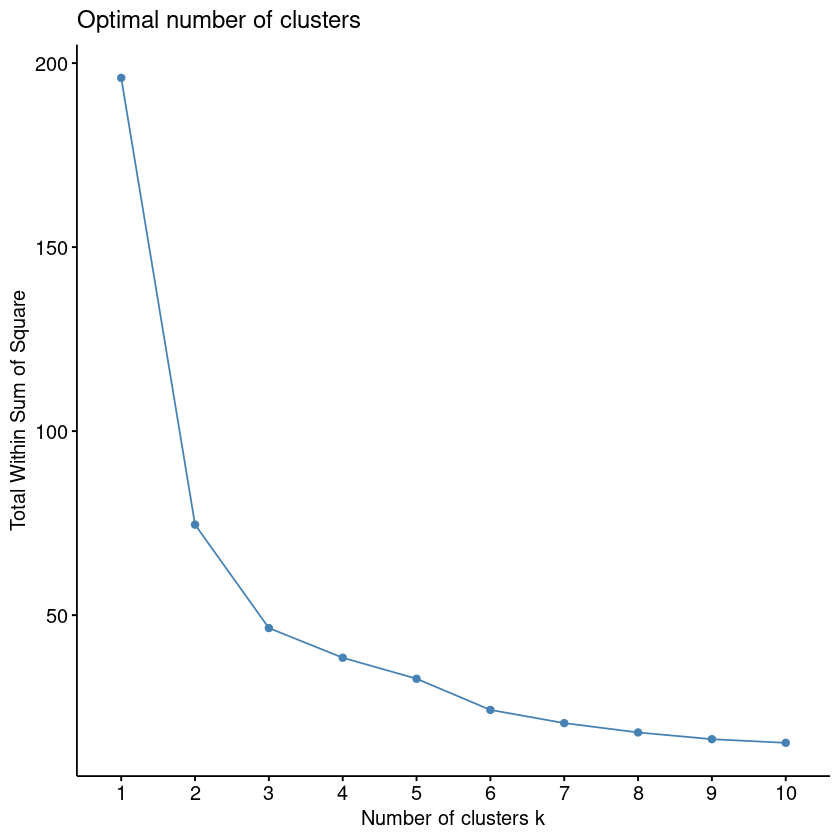

In [21]:
# Select and scale the relevant features and store as k_means_data
k_means_data <- degrees_clean %>%
                  select(Starting.Median.Salary, 
                         Mid.Career.Median.Salary, 
                         Percentile.10, Percentile.90) %>%
                  scale()
    
# Run the fviz_nbclust function with our selected data and method "wss"
elbow_method <- fviz_nbclust(k_means_data, FUNcluster=kmeans,
                                             method='wss')

# View the plot
elbow_method

## 4. The silhouette method
<p>Now we'll use it for the <strong>Silhouette Method</strong> as well, which evaluates the quality of clusters by how well each point fits within a cluster, maximizing average "silhouette" width.</p>

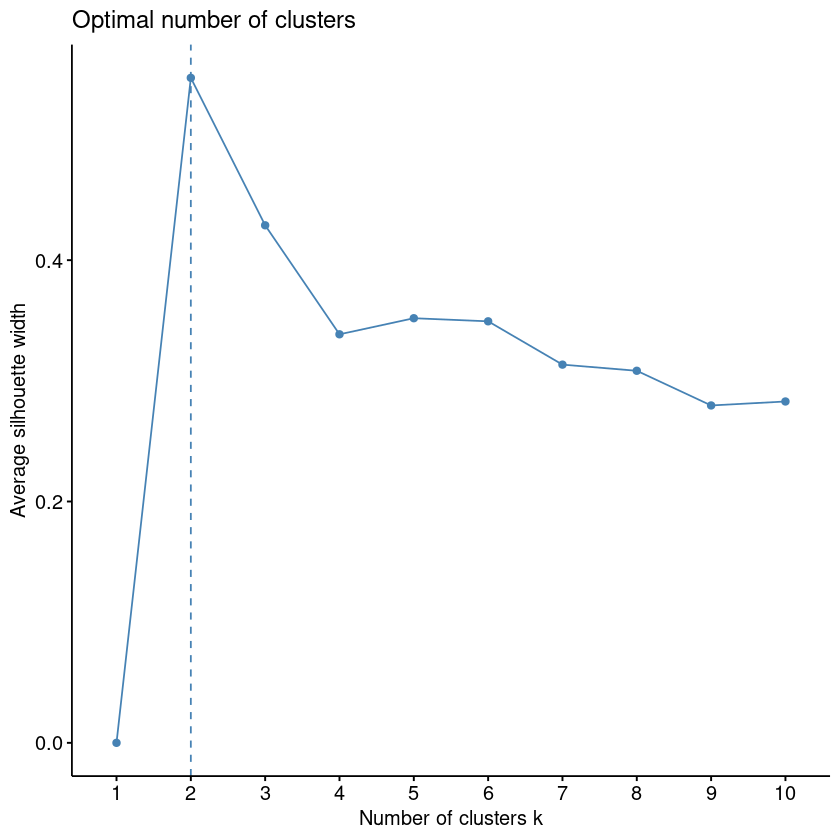

In [22]:
# Run the fviz_nbclust function with the method "silhouette" 
silhouette_method <- fviz_nbclust(k_means_data, FUNcluster=kmeans,
                                                   method='silhouette')

# View the plot
silhouette_method

## 5. The gap statistic method
<pIt seems that these two methods so far disagree on the optimal number of clusters… Time to pull out the tie breaker.</p>
<p>For our final method, let's see what the <strong>Gap Statistic Method</strong> has to say about this. The Gap Statistic Method will compare the total variation within clusters for different values of <em>k</em> to the null hypothesis, maximizing the "gap." We'll use the <code>clusGap</code> function to calculate this behind the scenes and the <code>fviz_gap_stat</code> function to visualize the results.</p>

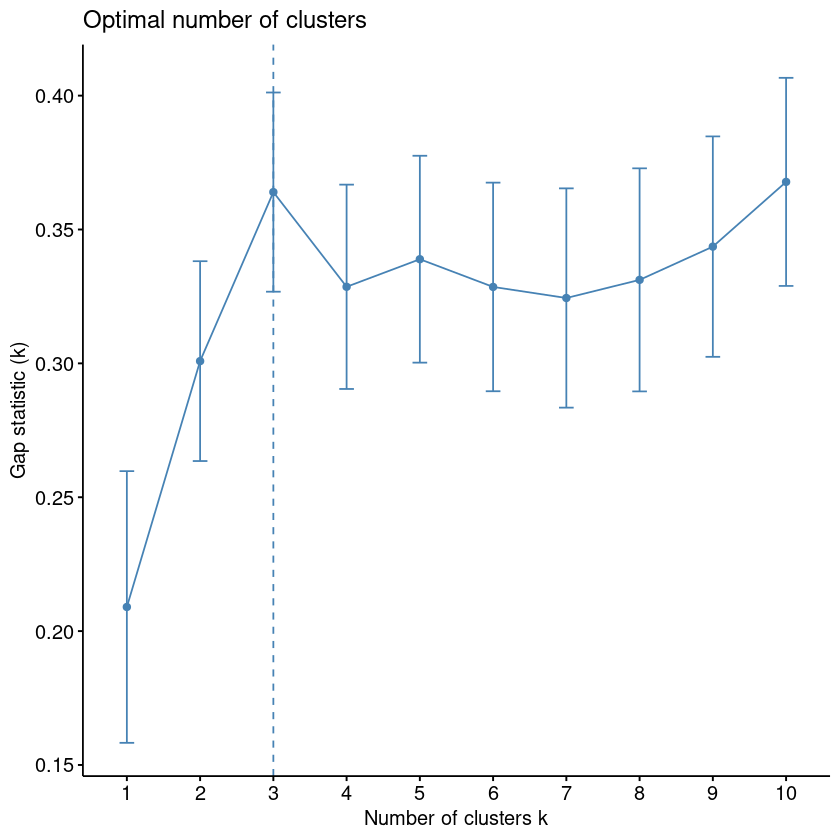

In [23]:
# Use the clusGap function to apply the Gap Statistic Method
gap_stat <- clusGap(k_means_data, FUN=kmeans, nstart=25, K.max=10, B=50)

# Use the fviz_gap_stat function to vizualize the results
gap_stat_method <- fviz_gap_stat(gap_stat)

# View the plot
gap_stat_method

## 6. K-means algorithm
<p>According to majority rule, I'll use 3 for our optimal number of clusters. With this information, we can now run our k-means algorithm on the selected data. We will then add the resulting cluster information to label our original dataframe.</p>

In [24]:
# Set a random seed
set.seed(83)

# Set k equal to the optimal number of clusters
num_clusters <- 3

# Run the k-means algorithm 
k_means <- kmeans(k_means_data, num_clusters, iter.max=15, 
                  nstart=25)

# Label the clusters of degrees_clean
degrees_labeled <- degrees_clean %>%
    mutate(clusters = k_means$cluster)

## 7. Visualizing the clusters
<p>Now let's visualize our results by taking a look at how each cluster compares in Starting vs. Mid Career Median Salaries.</p>

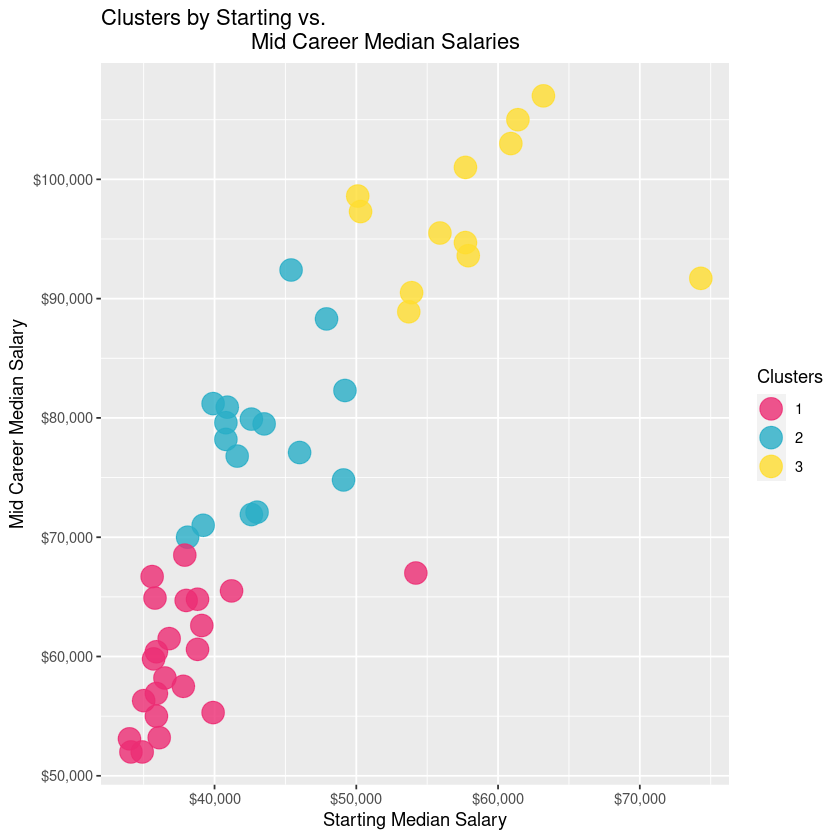

In [25]:
# Graph the clusters by Starting and Mid Career Median Salaries
career_growth <- ggplot(degrees_labeled, aes(Starting.Median.Salary,
                                             Mid.Career.Median.Salary,
                                             color=factor(clusters)))+
                 geom_point(alpha=0.8,size=6)+
                 xlab('Starting Median Salary')+
                 ylab('Mid Career Median Salary')+
                 scale_color_manual(name="Clusters",
                                    values=c("#EC2C73","#29AEC7",
                                             "#FFDD30")) +
                 ggtitle('Clusters by Starting vs. 
                         Mid Career Median Salaries') +
                 scale_x_continuous(labels = scales::dollar) +
                 scale_y_continuous(labels = scales::dollar) 

# View the plot
career_growth

## 8. A deeper dive into the clusters
<p>Unsurprisingly, most of the data points are hovering in the top left corner, with a relatively linear relationship. In other words, the higher your starting salary, the higher your mid career salary. The three clusters provide a level of delineation that intuitively supports this. </p>
<p>How might the clusters reflect potential mid career growth? There are also a couple curious outliers from clusters 1 and 3… perhaps this can be explained by investigating the mid career percentiles further, and exploring which majors fall in each cluster.</p>
<p>Right now, we have a column for each percentile salary value. In order to visualize the clusters and majors by mid career percentiles, we'll need to reshape the <code>degrees_labeled</code> data using tidyr's <code>gather</code> function to make a <code>percentile</code> <em>key</em> column and a <code>salary</code> <em>value</em> column to use for the axes of our following graphs. We'll then be able to examine the contents of each cluster to see what stories they might be telling us about the majors.</p>

In [26]:
# Use the gather function to reshape degrees and 
# use mutate() to reorder the new percentile column
degrees_perc <- degrees_labeled %>%
                  select(College.Major, Percentile.10, Percentile.25, 
                         Mid.Career.Median.Salary, Percentile.75, 
                         Percentile.90,clusters) %>%
                  gather(-c('College.Major', 'clusters'), key=percentile,
                         value=salary) %>%
                  mutate(percentile=factor(percentile,
                                           levels=c('Percentile.10',
                                                    'Percentile.25',
                                          'Mid.Career.Median.Salary',
                                                    'Percentile.75',
                                                    'Percentile.90')))

## 9. The liberal arts cluster
<p>Let's graph Cluster 1 and examine the results. These Liberal Arts majors may represent the lowest percentiles with limited growth opportunity, but there is hope for those who make it. Music is the riskiest major with the lowest 10th percentile salary, but Drama wins the highest growth potential in the 90th percentile for this cluster. Nursing is the outlier culprit of cluster number 1, with a higher safety net in the lowest percentile to the median. Otherwise, this cluster does represent the majors with limited growth opportunity.</p>

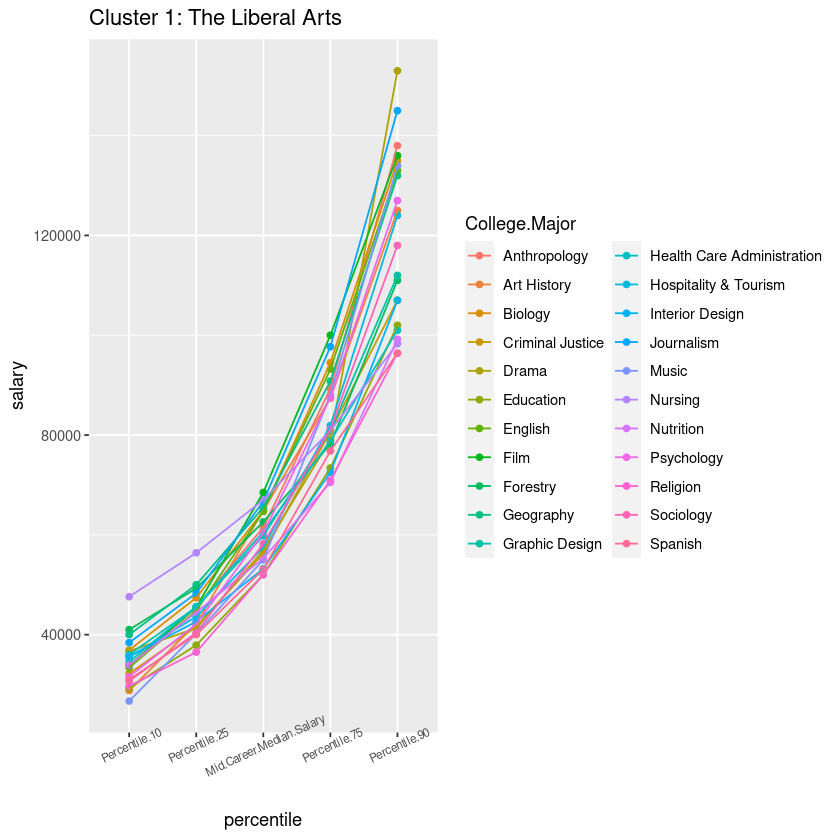

In [27]:
# Graph the majors of Cluster 1 by percentile
cluster_1 <- ggplot(degrees_perc[degrees_perc$clusters==1,],
                    aes(percentile, salary, group=College.Major,
                        color=College.Major, order=salary)) +
             geom_point() +
             geom_line()+
             ggtitle('Cluster 1: The Liberal Arts') +
             theme(axis.text.x=element_text(size=7, angle=25))
                       
# View the plot
cluster_1

## 10. The goldilocks cluster
<p>For Cluster 2, the majors of this cluster are fairly middle of the road in our dataset, starting off not too low and not too high in the lowest percentile. However, this cluster also represents the majors with the greatest differential between the lowest and highest percentiles. Accountants are known for having stable job security, but once you're in the big leagues you may be surprised to find that Marketing or Philosophy can ultimately result in higher salaries.</p>

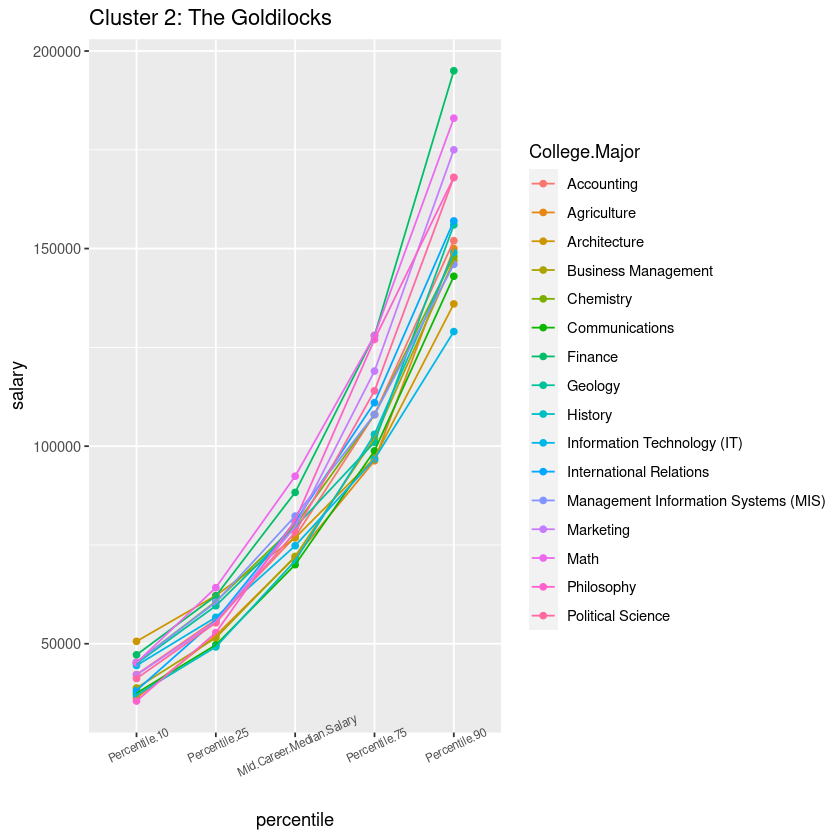

In [28]:
# Modify the previous plot to display Cluster 2
cluster_2 <- ggplot(degrees_perc[degrees_perc$clusters==2,],
                    aes(percentile, salary, group=College.Major,
                        color=College.Major, order=salary)) +
             geom_point() +
             geom_line()+
             ggtitle('Cluster 2: The Goldilocks') +
             theme(axis.text.x=element_text(size=7, angle=25))

# View the plot
cluster_2

## 11. The over achiever cluster
<p>Finally, let's visualize Cluster 3. Besides our one previously observed outlier now identifiable as Physician Assistant lagging in the highest percentiles, these heavy hitters and solid engineers represent the highest growth potential in the 90th percentile, as well as the best security in the 10th percentile rankings.</p>

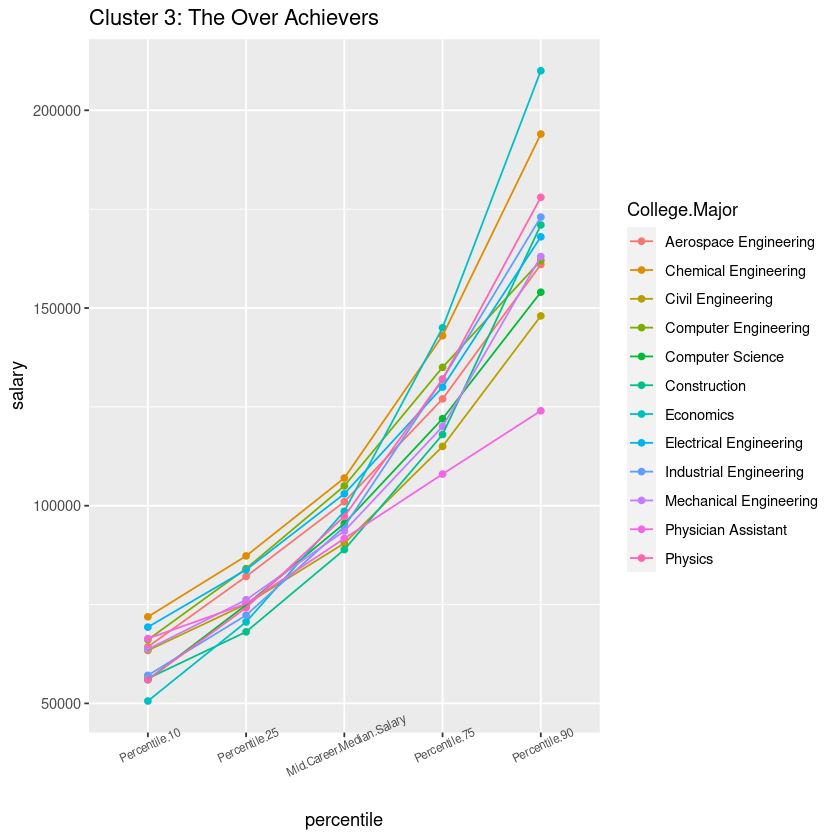

In [29]:
# Modify the previous plot to display Cluster 3
cluster_3 <- ggplot(degrees_perc[degrees_perc$clusters==3,],
                    aes(percentile, salary, group=College.Major,
                        color=College.Major, order=salary)) +
             geom_point() +
             geom_line()+
             ggtitle('Cluster 3: The Over Achievers') +
             theme(axis.text.x=element_text(size=7, angle=25))

# View the plot
cluster_3

## 12. Every major's wonderful
<p>Thus concludes the journey exploring salary projections by college major via a k-means clustering analysis. In this notebook, I dealt with unsupervized data, used three popular methods to determine the optimal number of clusters and also used visualizations to interpret the patterns revealed by our three clusters and tell a story. </p>
<p>While it's tempting to focus on starting career salaries when choosing a major, it's important to also consider the growth potential down the road. Whether a major falls into the Liberal Arts, Goldilocks, or Over Achievers cluster, one's financial destiny will certainly be influenced by numerous other factors including the school attended, location, passion or talent for the subject, and of course the actual career(s) pursued. </p>